# Shuffle-based Dimensional Importance (SDI) 기법 개발을 위한 실험 코드입니다.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset, base_transform, psa_dim, plot_psa_dim_scores

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


SDI 함수

In [18]:
def sdi_importance_analysis(model, data_loader, num_samples=1, perturbation_strength=0.2, target_dims=None):
    model.eval()

    sample_batch, _ = next(iter(data_loader))
    num_dims = len(sample_batch.shape) - 1
    dim_names = [f"dim_{i}" for i in range(1, num_dims + 1)]

    # 조사할 차원을 설정 (기본: 모든 차원)
    if target_dims is None:
        target_dims = dim_names
    else:
        target_dims = [f"dim_{i}" for i in target_dims]

    importance_scores = {dim: 0.0 for dim in target_dims}
    per_class_scores = {}

    num_batches = 0
    for X_batch, _ in data_loader:
        num_batches += 1
        X_batch = X_batch.to(next(model.parameters()).device)

        logit_original = model(X_batch).detach()
        num_classes = logit_original.shape[1]

        if not per_class_scores:
            per_class_scores = {cls: {dim: 0.0 for dim in target_dims} for cls in range(num_classes)}

        for dim_name in target_dims:
            dim_idx = dim_names.index(dim_name) + 1  # 1-based index
            total_mse = 0.0
            class_mse = {cls: 0.0 for cls in range(num_classes)}

            for _ in range(num_samples):
                X_perturbed = X_batch.clone().detach()
                num_swap = max(1, int(X_perturbed.shape[dim_idx] * perturbation_strength))
                swap_indices = random.sample(range(X_perturbed.shape[dim_idx]), num_swap)
                permutation = random.sample(swap_indices, len(swap_indices))

                X_perturbed.index_copy_(dim_idx, torch.tensor(swap_indices, device=X_batch.device),
                                        X_perturbed.index_select(dim_idx, torch.tensor(permutation, device=X_batch.device)))

                logit_perturbed = model(X_perturbed).detach()
                mse = torch.mean((logit_original - logit_perturbed) ** 2, dim=0)
                total_mse += mse.mean().item()

                for cls in range(num_classes):
                    class_mse[cls] += mse[cls].item()

            importance_scores[dim_name] += total_mse / num_samples
            for cls in range(num_classes):
                per_class_scores[cls][dim_name] += class_mse[cls] / num_samples

    for key in importance_scores:
        importance_scores[key] /= num_batches

    for cls in per_class_scores:
        for key in per_class_scores[cls]:
            per_class_scores[cls][key] /= num_batches

    # 🔹 선택한 차원만 정규화하여 합이 1이 되도록 조정
    total_score = sum(importance_scores.values())
    importance_scores = {key: value / total_score for key, value in importance_scores.items()} if total_score > 0 else importance_scores

    for cls in per_class_scores:
        class_total_score = sum(per_class_scores[cls].values())
        per_class_scores[cls] = {key: value / class_total_score for key, value in per_class_scores[cls].items()} if class_total_score > 0 else per_class_scores[cls]

    return {"overall": importance_scores, "per_class": per_class_scores}

visulaize 함수

In [19]:
def plot_importance_scores(importance_scores, per_class_scores):
    # Overall Dimension Importance (Bar Chart)
    plt.figure(figsize=(8, 5))
    plt.bar(importance_scores.keys(), importance_scores.values(), color='skyblue')
    plt.xlabel("Dimension")
    plt.ylabel("Importance Score")
    plt.title("Overall Dimension Importance")
    plt.xticks(rotation=45)
    plt.show()

    # Per-Class Importance (Heatmap)
    per_class_df = {cls: list(scores.values()) for cls, scores in per_class_scores.items()}
    dim_labels = list(per_class_scores[0].keys())  # Dimension names

    plt.figure(figsize=(10, 6))
    sns.heatmap(list(per_class_df.values()), annot=True, cmap="Blues", xticklabels=dim_labels, yticklabels=list(per_class_df.keys()))
    plt.xlabel("Dimension")
    plt.ylabel("Class")
    plt.title("Per-Class Dimension Importance")
    plt.show()


데이터셋 만들기 (Bands, Time, Height, Width)구조이다.

In [37]:
# 데이터 파라미터
num_samples = 10000  # 샘플 수
time_steps = 12     # 시간 차원
bands = 4          # 스펙트럼 밴드
height = 5         # 이미지 높이
width = 5          # 이미지 너비

X_class0 = np.zeros((num_samples, bands, time_steps, height, width))
X_class1 = np.zeros_like(X_class0)
X_class2 = np.zeros_like(X_class0)
X_class3 = np.zeros_like(X_class0)
X_class4 = np.zeros_like(X_class0)

# 1부터 2 사이의 100개의 값 중에서 num_samples개를 랜덤 선택
values = np.linspace(1, 2, 100).tolist()
material = torch.stack([#뽑은 값으로 (bands, height, width)크기의 텐서를 채운다.
    torch.full((bands, height, width), random.choice(values))
    for _ in range(num_samples)
])
#현재는 아무 규칙없이 하나의 숫자로 이루어 진 텐서이므로 이를 가지고는 분류를 수행 할 수 없다.

#dim_2의 규칙 부여 -> class0 or class3, class1 or class4, class2 중 어디에 속하는지를 구분 할 수 있게되었다.
for t in range(time_steps):
    X_class0[:, :, t, :, :] = material * (t - 6) ** 2
    X_class3[:, :, t, :, :] = material * (t - 6) ** 2

    X_class1[:, :, t, :, :] = material * (-1) ** t
    X_class4[:, :, t, :, :] = material * (-1) ** t

    X_class2[:, :, t, :, :] = material * (t - 6) ** 3

#dim_1의 규칙 부여 -> class0과 class3을 구분할 수 있게된다.
X_class3[:, 0, :, :, :] = 0

#dim_3의 규칙 부여 -> class1과 class4를 구분할 수 있게된다.
X_class4[:, :, :, 0, :] = 0

# 레이블 할당
y_class0 = np.zeros(num_samples)
y_class1 = np.ones(num_samples)
y_class2 = np.full(num_samples, 2)
y_class3 = np.full(num_samples, 3)
y_class4 = np.full(num_samples, 4)

# 데이터 병합
X = np.concatenate([X_class0, X_class1, X_class2, X_class3, X_class4], axis=0)  # (Samples * 3, Bands, Time, Height, Width)
y = np.concatenate([y_class0, y_class1, y_class2, y_class3, y_class4], axis=0)  # (Samples * 3,)

# PyTorch Tensor 변환
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)

print("데이터 Shape:", X.shape)  # (300, 4, 12, 5, 5)
print("레이블 Shape:", y.shape)  # (300,)

batch_size = 4 #local min에 빠지지 않도록 작게 설정

# 데이터 로더 생성
train_loader = torch.utils.data.DataLoader(list(zip(X, y)), batch_size=batch_size, shuffle=True)

데이터 Shape: torch.Size([50000, 4, 12, 5, 5])
레이블 Shape: torch.Size([50000])


간단한 모델 정의(ResNet-like 구조의 2+1D CNN 모델을 사용합니다.)

In [38]:
class EnhancedVideoClassifier(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.5):
        super().__init__()
        # Feature Extraction Block 1
        self.block1 = nn.Sequential(
            nn.Conv3d(4, 32, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(32, 32, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d((1,2,2), stride=(1,2,2))
        )

        # Feature Extraction Block 2 with Residual Connection
        self.block2 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 64, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d((2,2,2), stride=(2,2,2))
        )

        # Feature Extraction Block 3
        self.block3 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.Conv3d(128, 128, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1,1,1))
        )

        # Classification Head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(dropout_prob/2),
            nn.Linear(256, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.block1(x)  # [B, 32, T, H/2, W/2]
        x = self.block2(x)  # [B, 64, T/2, H/4, W/4]
        x = self.block3(x)  # [B, 128, 1, 1, 1]
        x = x.view(x.size(0), -1)
        return self.classifier(x)

num_classes = 5
model = EnhancedVideoClassifier(num_classes)
model.to(device)


EnhancedVideoClassifier(
  (block1): Sequential(
    (0): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=

모델 학습

In [39]:
# 학습 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0  # 맞힌 개수
    total = 0    # 전체 개수

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.float()  # float64 → float32 변환
        y_batch = y_batch.long()   # 정수형 변환 (필요 시)

        optimizer.zero_grad()
        logits = model(X_batch)  # Forward pass
        loss = criterion(logits, y_batch)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트
        total_loss += loss.item()

        # 🔹 정확도 계산
        preds = torch.argmax(logits, dim=1)  # 가장 높은 확률의 클래스 선택
        correct += preds.eq(y_batch).sum().item()  # 맞힌 개수 누적
        total += y_batch.size(0)  # 전체 샘플 개수 누적

    # 🔹 평균 Loss 및 Accuracy 출력
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total * 100  # 퍼센트(%)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch 1/5, Loss: 0.2189, Accuracy: 87.34%
Epoch 2/5, Loss: 0.0130, Accuracy: 99.67%
Epoch 3/5, Loss: 0.0035, Accuracy: 99.89%
Epoch 4/5, Loss: 0.0015, Accuracy: 99.97%
Epoch 5/5, Loss: 0.0026, Accuracy: 99.96%


잘 학습이 되었다.

SDI 수행

전체 차원 중요도: {'dim_1': 0.0790776752253713, 'dim_2': 0.8648006191525105, 'dim_3': 0.05612170562211824, 'dim_4': 0.0}
클래스별 차원 중요도:
  클래스 0: {'dim_1': 0.08763508837673488, 'dim_2': 0.9090084238095211, 'dim_3': 0.003356487813744093, 'dim_4': 0.0}
  클래스 1: {'dim_1': 0.02118620730798263, 'dim_2': 0.7953486542299298, 'dim_3': 0.18346513846208745, 'dim_4': 0.0}
  클래스 2: {'dim_1': 0.04896784182650616, 'dim_2': 0.9465957005019423, 'dim_3': 0.00443645767155149, 'dim_4': 0.0}
  클래스 3: {'dim_1': 0.1174995906916794, 'dim_2': 0.8803280166522057, 'dim_3': 0.002172392656114763, 'dim_4': 0.0}
  클래스 4: {'dim_1': 0.08723722060196443, 'dim_2': 0.7746058484231352, 'dim_3': 0.13815693097490028, 'dim_4': 0.0}


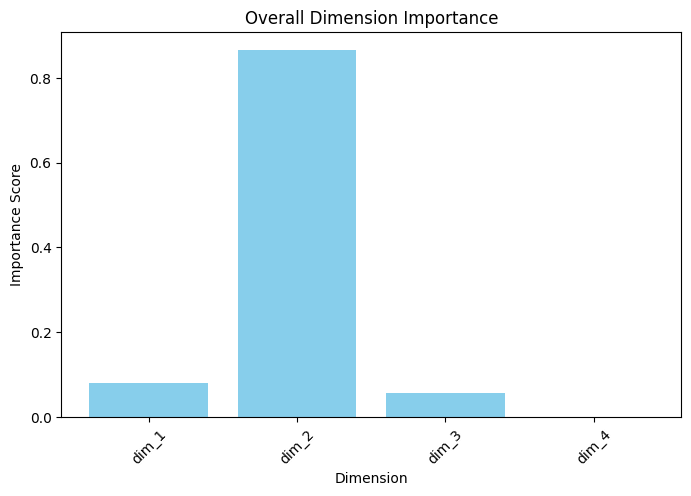

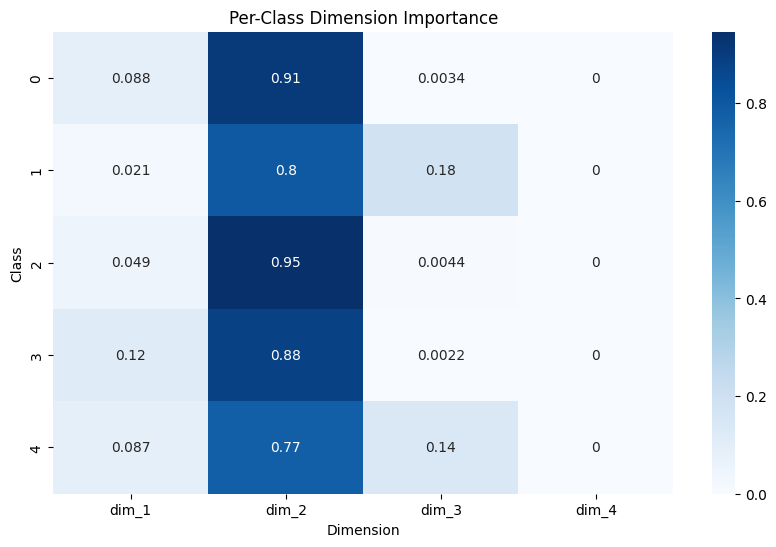

In [29]:
perturbation_scores = sdi_importance_analysis(model, train_loader, num_samples=3, perturbation_strength=0.8)

print("전체 차원 중요도:", perturbation_scores["overall"])
print("클래스별 차원 중요도:")
for cls, scores in perturbation_scores["per_class"].items():
    print(f"  클래스 {cls}: {scores}")

plot_importance_scores(perturbation_scores["overall"], perturbation_scores["per_class"])

모든 class에서 예상대로 dim_2가 가장 중요하게 사용되었다.  
또, 예상대로 class0, class3에서는 dim_1이 추가로 중요하게 고려 되었고(이 둘의 차이는 dim_1에서 나타나기 때문)
마찬가지로 class1, class4에서 dim_3가 중요하게 고려 되었다.(이 둘의 차이는 dim_0에서 나타남)

# 이제 우리 모델에 SDI를 적용해보자

In [3]:
from torch.utils.data import DataLoader
from torchvision import transforms
from utils.utils import TiffDataset
from models.video_classifier import VideoClassifier

In [4]:
# 테스트 필터 정의
test_filter = lambda box_number: (box_number % 9 == 0 or box_number % 9 == 5)

In [5]:
class ReshapeTransform:
    """(12*bands, 3, 3) → (12, bands, 3, 3) 변환"""
    def __init__(self, bands):
        self.bands = bands

    def __call__(self, x):
        return x.view(12, self.bands, 3, 3).permute(1, 0, 2, 3)

def get_transform(bands, scale_channels_func=None):
    transform_list = [
        transforms.ToTensor(),  # (H, W, C) → (C, H, W)
        transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
        ReshapeTransform(bands)  # (12*bands, 3, 3) → (bands, 12, 3, 3)
    ]

    if scale_channels_func:
        transform_list.append(transforms.Lambda(scale_channels_func))  # 채널별 값 조정 추가

    return transforms.Compose(transform_list)

#scaling 함수 - 채널별로 범위의 차이가 크기때문에 어느정도 맞추어주기 위해서 수행
def scale_channels(x):
    """특정 채널값 조정"""
    x[0:3] *= 5  # B,G,R 채널 * 5
    if 4 < x.shape[0]:
        x[4] *= 0.5  # NDVI 채널 * 0.5
    return x

In [6]:
large_tif_dir = '../../data/source_data/naive' #원천데이터 주소
bands = 4 #밴드 수

transform = get_transform(bands, scale_channels)

train_dataset = TiffDataset(
    large_tif_dir = large_tif_dir,
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = "../../data/label_data/species/label_mapping_sampled.csv",
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform
)

val_dataset = TiffDataset(
    large_tif_dir = large_tif_dir,
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file ="../../data/label_data/species/label_mapping_sampled.csv",
    box_filter_fn = test_filter,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

모델 가져오기

In [10]:
stage_repeats = [2, 2, 4, 3]  # 각 stage에서 ResBlock 반복 횟수
stage_channels = [16, 32, 64, 128]  # 각 stage의 채널 크기
num_classes = 6  # 분류할 클래스 개수

# 모델 생성
model = VideoClassifier(bands, stage_repeats, stage_channels, num_classes=num_classes).to(device)
model.load_state_dict(torch.load(f"./checkpoints/video_classification_enhanced/cnn_4_9_100.pth", map_location=device))

<All keys matched successfully>

SDI 수행

Processing batches: 100%|███████████████████████████████████████████████████| 3523/3523 [07:24<00:00,  7.92it/s]


전체 차원 중요도: {'dim_1': 0.6277101685142903, 'dim_2': 0.34518230442446696, 'dim_3': 0.00995207141643385, 'dim_4': 0.017155455644808963}
클래스별 차원 중요도:
  클래스 0: {'dim_1': 0.7996560435613372, 'dim_2': 0.1788748462670157, 'dim_3': 0.00736468142868312, 'dim_4': 0.014104428742963963}
  클래스 1: {'dim_1': 0.5497837722778892, 'dim_2': 0.419957503924925, 'dim_3': 0.011375928078555751, 'dim_4': 0.018882795718630017}
  클래스 2: {'dim_1': 0.6141595561448324, 'dim_2': 0.35776565443595026, 'dim_3': 0.01075823420424515, 'dim_4': 0.01731655521497219}
  클래스 3: {'dim_1': 0.499725279189619, 'dim_2': 0.4713169362809478, 'dim_3': 0.011058204496773907, 'dim_4': 0.01789958003265936}
  클래스 4: {'dim_1': 0.5574037957476278, 'dim_2': 0.4149720082537704, 'dim_3': 0.01029850075130253, 'dim_4': 0.017325695247299253}
  클래스 5: {'dim_1': 0.5032894980802395, 'dim_2': 0.46546195057881323, 'dim_3': 0.01149786335433888, 'dim_4': 0.019750687986608485}


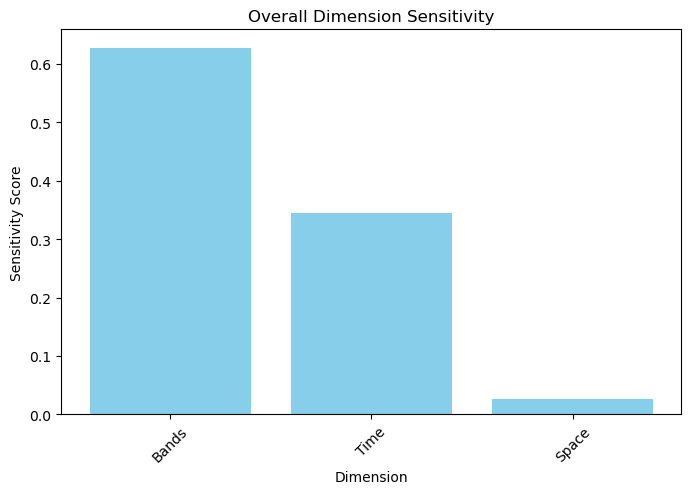

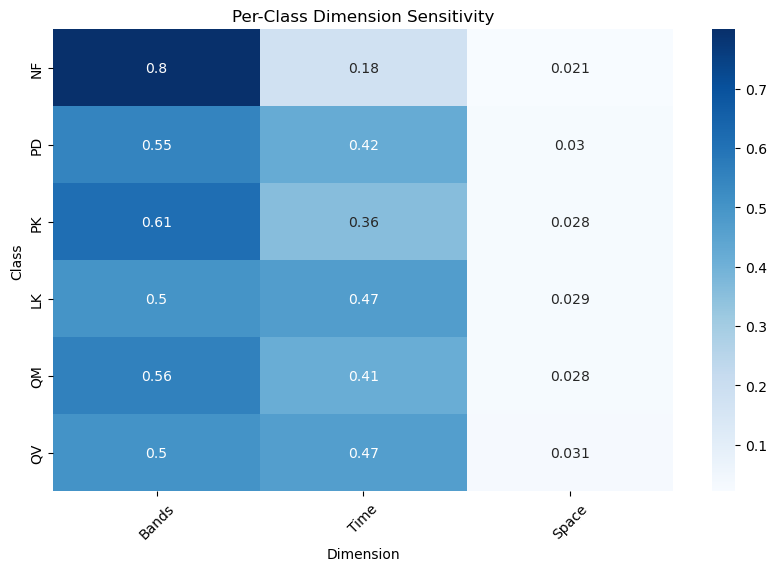

In [11]:
perturbation_scores = psa_dim(model, train_loader, num_repeats=3, perturbation_strength=0.8, normalize=True)

print("전체 차원 중요도:", perturbation_scores["overall"])
print("클래스별 차원 중요도:")
for cls, scores in perturbation_scores["per_class"].items():
    print(f"  클래스 {cls}: {scores}")
    
plot_psa_dim_scores(perturbation_scores["overall"], perturbation_scores["per_class"])

밴드차원(dim_1), 시간차원(dim_2)가가 중요하게 사용되었다.  
밴드를 바꾸면 모델이 많이 망가지는 것은 당연하다.  
시간과 공간만을 비교해보자

전체 차원 중요도: {'dim_2': 0.9856631081139422, 'dim_3': 0.00642911920623221, 'dim_4': 0.007907772679825504}
클래스별 차원 중요도:
  클래스 0: {'dim_2': 0.9803176820320305, 'dim_3': 0.008015539084409478, 'dim_4': 0.011666778883559817}
  클래스 1: {'dim_2': 0.9841439037255978, 'dim_3': 0.00790910461067774, 'dim_4': 0.007946991663724513}
  클래스 2: {'dim_2': 0.9901129305487624, 'dim_3': 0.004709200980328976, 'dim_4': 0.005177868470908648}
  클래스 3: {'dim_2': 0.9867623459685421, 'dim_3': 0.00615701718484162, 'dim_4': 0.007080636846616293}
  클래스 4: {'dim_2': 0.990954732732436, 'dim_3': 0.003945388609618852, 'dim_4': 0.005099878657945174}
  클래스 5: {'dim_2': 0.9833377580259035, 'dim_3': 0.007471087611793529, 'dim_4': 0.009191154362302934}
  클래스 6: {'dim_2': 0.9837987351040536, 'dim_3': 0.007394684171278467, 'dim_4': 0.008806580724667964}
  클래스 7: {'dim_2': 0.982838709441192, 'dim_3': 0.007776611616727019, 'dim_4': 0.009384678942080922}


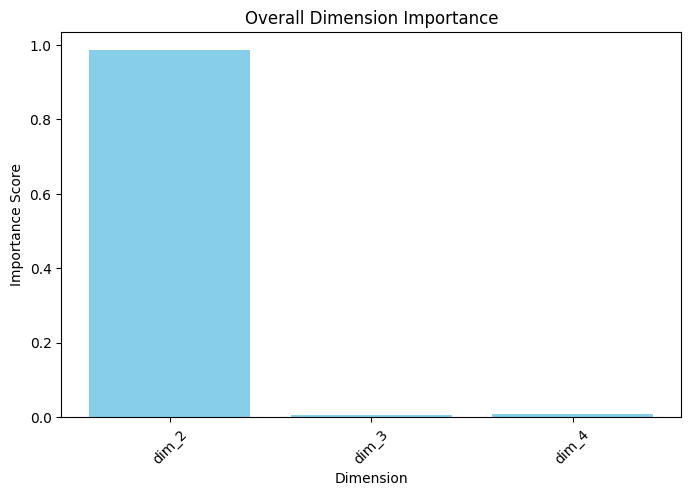

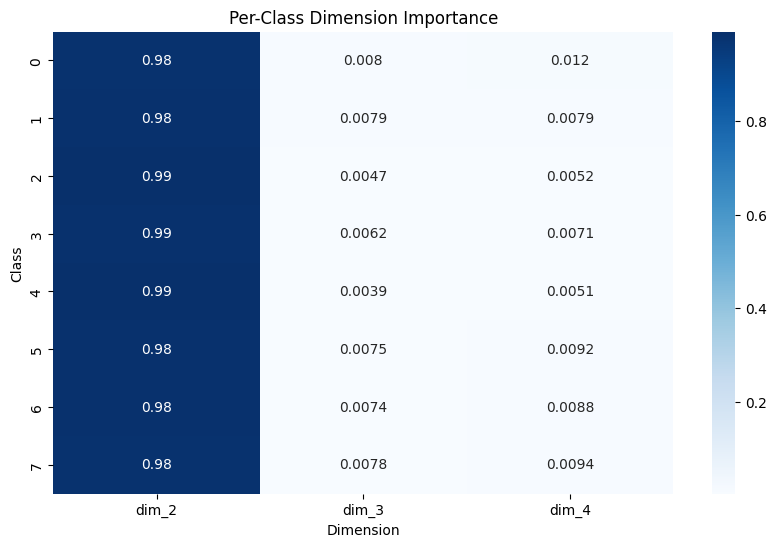

In [36]:
perturbation_scores = sdi_importance_analysis(model, train_loader, num_samples=3, perturbation_strength=0.8, target_dims=[2, 3, 4])

print("전체 차원 중요도:", perturbation_scores["overall"])
print("클래스별 차원 중요도:")
for cls, scores in perturbation_scores["per_class"].items():
    print(f"  클래스 {cls}: {scores}")
plot_importance_scores(perturbation_scores["overall"], perturbation_scores["per_class"])

예상했던 대로, 시간 차원이 압도적으로 훨씬 중요하게 사용된것을 볼 수 있다.  
현재 공간 차원을 사용하기에는 패치사이즈가 너무 작을 수도 있다.  
더 큰(ex. 11) patch_size를 사용한다면 공간정보가 더 유의미해 질 수 도 있을 것이다.  

-> 더 큰 patch_size를 이용하는 video_classification 모델 학습후 재 분석 해보기